In [3]:
!pip install -q segmentation-models-pytorch timm \
             torchmetrics albumentations





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which

In [2]:
from sklearn.model_selection import train_test_split
import pandas as pd
import zipfile, os, shutil, random, pathlib
import pathlib, random, zipfile, os
import pandas as pd, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm



from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
)
import segmentation_models_pytorch as smp

SEED       = 42
IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS_BL  = 10
EPOCHS_IMP = 20
torch.manual_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


DATA_DIR = pathlib.Path("/kaggle/input/realwaste/realwaste-main/RealWaste")
all_images = []
for class_idx, class_name in enumerate(sorted(p.name for p in DATA_DIR.iterdir())):
    for img_path in (DATA_DIR / class_name).glob("*"):
        all_images.append((img_path, class_idx, class_name))

df = pd.DataFrame(all_images, columns=["path", "label", "class"])
train_df, tmp_df = train_test_split(
    df, test_size=0.30, random_state=42, stratify=df["label"]
)
val_df, test_df  = train_test_split(
    tmp_df, test_size=0.50, random_state=42, stratify=tmp_df["label"]
)
print(f"train {len(train_df)}, val {len(val_df)}, test {len(test_df)}")

train 3326, val 713, test 713


In [3]:
import timm
import segmentation_models_pytorch as smp
print(list(k for k in smp.encoders.encoders.keys()
           if k.startswith("timm-vit") )[:5])
print([k for k in smp.encoders.encoders if "vit" in k][:10])
import segmentation_models_pytorch as smp
print([k for k in smp.encoders.encoders if k.startswith("timm")])


[]
[]
['timm-efficientnet-b0', 'timm-efficientnet-b1', 'timm-efficientnet-b2', 'timm-efficientnet-b3', 'timm-efficientnet-b4', 'timm-efficientnet-b5', 'timm-efficientnet-b6', 'timm-efficientnet-b7', 'timm-efficientnet-b8', 'timm-efficientnet-l2', 'timm-tf_efficientnet_lite0', 'timm-tf_efficientnet_lite1', 'timm-tf_efficientnet_lite2', 'timm-tf_efficientnet_lite3', 'timm-tf_efficientnet_lite4', 'timm-skresnet18', 'timm-skresnet34', 'timm-skresnext50_32x4d']


In [4]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])

val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])


In [5]:
class WasteDataset(Dataset):
    def __init__(self, frame, tfm):
        self.f, self.tfm = frame.reset_index(drop=True), tfm
    def __len__(self): return len(self.f)
    def __getitem__(self, i):
        img = Image.open(self.f.loc[i,"path"]).convert("RGB")
        return self.tfm(img), self.f.loc[i,"label"]

train_dl = DataLoader(WasteDataset(train_df, train_tfms),
                      batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=0, pin_memory=True)
val_dl   = DataLoader(WasteDataset(val_df, val_tfms),
                      batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)
test_dl  = DataLoader(WasteDataset(test_df, val_tfms),
                      batch_size=BATCH_SIZE, num_workers=0, pin_memory=True)


In [6]:
NUM_CLASSES = df.label.nunique()
metrics = {
    "acc"      : MulticlassAccuracy(NUM_CLASSES, average="micro").to(device),
    "f1_macro" : MulticlassF1Score(NUM_CLASSES, average="macro").to(device),
    "f1_weight": MulticlassF1Score(NUM_CLASSES, average="weighted").to(device),
    "top3"     : MulticlassAccuracy(NUM_CLASSES, top_k=3).to(device),
    "cm"       : MulticlassConfusionMatrix(NUM_CLASSES).to(device),
}


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
def train_one_epoch(model, loader, opt, sched):
    model.train(); run_loss = 0.0
    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

        opt.zero_grad(set_to_none=True)

        out    = model(xb)                     # ← ① forward
        logits = out[1] if isinstance(out, tuple) else out
        loss   = F.cross_entropy(logits, yb)   # ← ② классификационный loss

        loss.backward(); opt.step(); sched.step()
        run_loss += loss.item() * xb.size(0)
    return run_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    for m in metrics.values(): m.reset()
    model.eval(); run_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        out    = model(xb)                     # ← ①
        logits = out[1] if isinstance(out, tuple) else out
        loss   = F.cross_entropy(logits, yb)

        run_loss += loss.item() * xb.size(0)
        for m in metrics.values(): m.update(logits, yb)
    res = {"loss": run_loss / len(loader.dataset)}
    res.update({k: m.compute().cpu().numpy() if k=="cm" else m.compute().item()
                for k,m in metrics.items()})
    return res


#### REsnet 34

In [9]:
aux = dict(pooling="avg", classes=NUM_CLASSES, dropout=0.0, activation=None)
cnn = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",
               classes=1, aux_params=aux).to(device)

opt  = torch.optim.AdamW(cnn.parameters(), lr=1e-4, weight_decay=1e-4)
sched= torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
        steps_per_epoch=len(train_dl), epochs=EPOCHS_BL)

best_f1, best_wts = 0, None
for epoch in range(EPOCHS_BL):
    t_loss = train_one_epoch(cnn, train_dl, opt, sched)
    val_stats = evaluate(cnn, val_dl)
    print(f"[{epoch+1:02d}] "
        f"loss_tr={t_loss:.3f} | loss_val={val_stats['loss']:.3f} | "
        f"Acc={val_stats['acc']:.3%} | "
        f"F1(ma)={val_stats['f1_macro']:.3%} | F1(we)={val_stats['f1_weight']:.3%} | "
        f"Top-3={val_stats['top3']:.3%}")
    if val_stats['f1_macro'] > best_f1:
        best_f1, best_wts = val_stats['f1_macro'], cnn.state_dict()
cnn.load_state_dict(best_wts)


  0%|          | 0/104 [00:00<?, ?it/s]

[01] loss_tr=0.959 | loss_val=0.782 | Acc=73.633% | F1(ma)=73.009% | F1(we)=73.550% | Top-3=96.838%


  0%|          | 0/104 [00:00<?, ?it/s]

[02] loss_tr=0.934 | loss_val=3.079 | Acc=50.351% | F1(ma)=45.610% | F1(we)=47.531% | Top-3=75.805%


  0%|          | 0/104 [00:00<?, ?it/s]

[03] loss_tr=0.808 | loss_val=1.063 | Acc=63.114% | F1(ma)=61.612% | F1(we)=63.344% | Top-3=93.687%


  0%|          | 0/104 [00:00<?, ?it/s]

[04] loss_tr=0.557 | loss_val=0.899 | Acc=72.370% | F1(ma)=73.056% | F1(we)=72.156% | Top-3=94.569%


  0%|          | 0/104 [00:00<?, ?it/s]

[05] loss_tr=0.456 | loss_val=0.704 | Acc=76.858% | F1(ma)=76.991% | F1(we)=77.107% | Top-3=96.487%


  0%|          | 0/104 [00:00<?, ?it/s]

[06] loss_tr=0.298 | loss_val=0.639 | Acc=80.505% | F1(ma)=80.866% | F1(we)=80.357% | Top-3=96.411%


  0%|          | 0/104 [00:00<?, ?it/s]

[07] loss_tr=0.174 | loss_val=0.396 | Acc=87.798% | F1(ma)=88.130% | F1(we)=87.676% | Top-3=98.381%


  0%|          | 0/104 [00:00<?, ?it/s]

[08] loss_tr=0.086 | loss_val=0.345 | Acc=89.481% | F1(ma)=89.657% | F1(we)=89.413% | Top-3=99.238%


  0%|          | 0/104 [00:00<?, ?it/s]

[09] loss_tr=0.050 | loss_val=0.342 | Acc=90.463% | F1(ma)=90.715% | F1(we)=90.414% | Top-3=98.841%


  0%|          | 0/104 [00:00<?, ?it/s]

[10] loss_tr=0.030 | loss_val=0.316 | Acc=90.603% | F1(ma)=90.908% | F1(we)=90.567% | Top-3=98.748%


<All keys matched successfully>

#### ViT

In [12]:
vit = smp.Unet(encoder_name="timm-efficientnet-b0",
               encoder_weights="imagenet", classes=1, aux_params=aux).to(device)

opt  = torch.optim.AdamW(vit.parameters(), lr=1e-4, weight_decay=1e-4)
sched= torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-3,
        steps_per_epoch=len(train_dl), epochs=EPOCHS_BL)

best_f1, best_wts = 0, None
for epoch in range(EPOCHS_BL):
    tl = train_one_epoch(vit, train_dl, opt, sched)
    vs = evaluate(vit, val_dl)
    print(f"[{epoch+1:02d}] "
        f"loss_tr={tl:.3f} | loss_val={vs['loss']:.3f} | "
        f"Acc={vs['acc']:.3%} | "
        f"F1(ma)={vs['f1_macro']:.3%} | F1(we)={vs['f1_weight']:.3%} | "
        f"Top-3={vs['top3']:.3%}")
    if vs['f1_macro'] > best_f1:
        best_f1, best_wts = vs['f1_macro'], vit.state_dict()
vit.load_state_dict(best_wts)


  0%|          | 0/104 [00:00<?, ?it/s]

[01] loss_tr=1.568 | loss_val=0.625 | Acc=78.822% | F1(ma)=78.560% | F1(we)=78.498% | Top-3=95.624%


  0%|          | 0/104 [00:00<?, ?it/s]

[02] loss_tr=0.526 | loss_val=0.506 | Acc=83.590% | F1(ma)=83.644% | F1(we)=83.679% | Top-3=97.053%


  0%|          | 0/104 [00:00<?, ?it/s]

[03] loss_tr=0.478 | loss_val=0.749 | Acc=79.383% | F1(ma)=78.774% | F1(we)=79.624% | Top-3=96.733%


  0%|          | 0/104 [00:00<?, ?it/s]

[04] loss_tr=0.428 | loss_val=0.478 | Acc=87.377% | F1(ma)=87.875% | F1(we)=87.377% | Top-3=97.816%


  0%|          | 0/104 [00:00<?, ?it/s]

[05] loss_tr=0.210 | loss_val=0.393 | Acc=89.762% | F1(ma)=90.190% | F1(we)=89.661% | Top-3=97.484%


  0%|          | 0/104 [00:00<?, ?it/s]

[06] loss_tr=0.108 | loss_val=0.332 | Acc=90.042% | F1(ma)=90.554% | F1(we)=89.954% | Top-3=98.534%


  0%|          | 0/104 [00:00<?, ?it/s]

[07] loss_tr=0.044 | loss_val=0.311 | Acc=91.445% | F1(ma)=91.861% | F1(we)=91.416% | Top-3=98.127%


  0%|          | 0/104 [00:00<?, ?it/s]

[08] loss_tr=0.029 | loss_val=0.330 | Acc=91.585% | F1(ma)=91.987% | F1(we)=91.526% | Top-3=98.127%


  0%|          | 0/104 [00:00<?, ?it/s]

[09] loss_tr=0.015 | loss_val=0.315 | Acc=92.286% | F1(ma)=92.865% | F1(we)=92.254% | Top-3=97.977%


  0%|          | 0/104 [00:00<?, ?it/s]

[10] loss_tr=0.018 | loss_val=0.315 | Acc=92.286% | F1(ma)=92.866% | F1(we)=92.237% | Top-3=97.966%


<All keys matched successfully>


ResNet-34 UNet — confusion matrix:
[[ 63   0   0   0   1   3   2   0   0]
 [  0  57   0   1   0   0   1   0   2]
 [  0   0  60   0   1   0   2   0   0]
 [  1   0   2 110   1   0   5   0   0]
 [  0   0   1   4  61   0   3   4   1]
 [  2   0   0   0   0  73   0   0   0]
 [  1   2   4  11   1   0 118   1   0]
 [  1   0   0   1   6   0   0  40   0]
 [  0   1   0   0   1   0   0   0  64]]


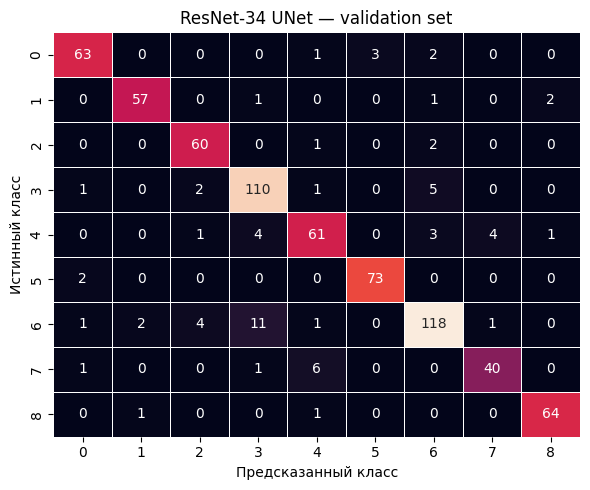


ViT-b0 UNet — confusion matrix:
[[ 67   0   0   0   0   2   0   0   0]
 [  0  60   0   0   0   0   0   0   1]
 [  0   1  58   1   0   0   3   0   0]
 [  1   0   2 110   1   1   4   0   0]
 [  0   0   0   3  64   0   5   0   2]
 [  0   0   0   0   0  74   0   1   0]
 [  2   2   3   9   3   0 118   1   0]
 [  0   0   0   0   4   1   0  43   0]
 [  0   2   0   0   0   0   0   0  64]]


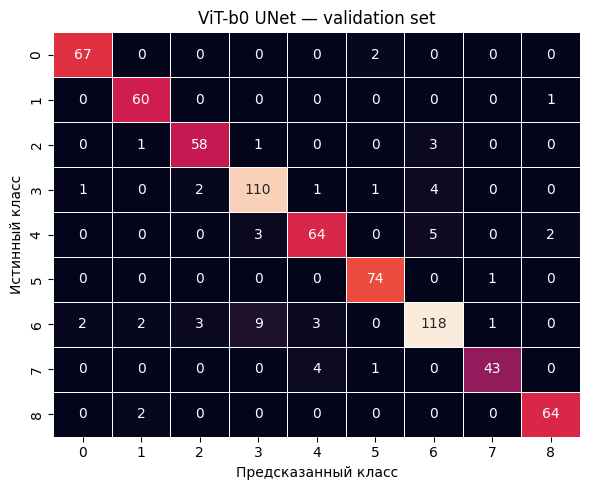

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
class_names = sorted(df.label.unique())          # или свой список

# модели, которые у вас уже есть в памяти
models = [
    ("ResNet-34 UNet", cnn),   # cnn уже содержит лучшие веса
    ("ViT-b0 UNet",   vit),    # vit тоже содержит лучшие веса
]

for title, mdl in models:
    mdl.eval()                               # на всякий случай
    vs = evaluate(mdl, val_dl)               # ──> возвращает словарь
    cm = vs["cm"]                            # сама confusion-matrix

    # 1) быстрый текстовый вывод
    print(f"\n{title} — confusion matrix:")
    print(cm)

    # 2) красивый heat-map
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True, fmt="d",                 # уберите annot=True, если классов много
        xticklabels=class_names,
        yticklabels=class_names,
        linewidths=.5, cbar=False,
    )
    plt.title(f"{title} — validation set")
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Истинный класс")
    plt.tight_layout()
    plt.show()

# Улучшение бейзлайна

In [32]:
import albumentations as A, importlib
print("Albumentations version →", A.__version__)


Albumentations version → 2.0.4


In [36]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 224          

# ---------- train ----------
train_tfms = A.Compose(
    [

        A.RandomResizedCrop(
            size=(IMG_SIZE, IMG_SIZE),     
            scale=(0.7, 1.0),              
            ratio=(0.75, 1.333),          
            p=1.0,
        ),

        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.RandomRotate90(p=0.3),

        A.ColorJitter(
            brightness=0.2, contrast=0.2,
            saturation=0.2, hue=0.1, p=0.5
        ),
        A.CLAHE(p=0.2),
        A.RandomBrightnessContrast(p=0.3),

        
        A.CoarseDropout(
            num_holes_range=(1, 1),           
            hole_height_range=(0.25, 0.25),    
            hole_width_range=(0.25, 0.25),     
            p=0.3,
        ),

        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        ToTensorV2(),
    ],
    strict=True,         
)

valid_tfms = A.Compose(
    [
        A.Resize(height=IMG_SIZE, width=IMG_SIZE),
        A.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225),
        ),
        ToTensorV2(),
    ],
    strict=True,
)


In [39]:
import torch, torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

opt_cnn = torch.optim.AdamW(cnn.parameters(), lr=3e-4, weight_decay=1e-2)
opt_vit = torch.optim.AdamW(vit.parameters(), lr=5e-5, weight_decay=1e-2)

sch_cnn = CosineAnnealingWarmRestarts(opt_cnn, T_0=4, T_mult=2)
sch_vit = CosineAnnealingWarmRestarts(opt_vit, T_0=4, T_mult=2)


In [40]:
def toggle_backbone(model, freeze: bool):
    for n, p in model.named_parameters():
        p.requires_grad = not freeze or n.startswith(("fc", "head", "classifier"))

toggle_backbone(cnn, True)
toggle_backbone(vit, True)


In [41]:
toggle_backbone(cnn, False)
toggle_backbone(vit, False)
for g in opt_cnn.param_groups: g["lr"] = 1e-4
for g in opt_vit.param_groups: g["lr"] = 2e-5


In [50]:
import torch
from tqdm.auto import tqdm

# Перед улучшенным обучением убедимся, что все слои разморожены
# и могут учиться (loss.backward не должен падать из-за отсутствия градиентов).
toggle_backbone(cnn, False)
toggle_backbone(vit, False)

# Функция тренировки с label smoothing и CosineAnnealingWarmRestarts
# Проверяем, что loss.requires_grad == True во избежание ошибок.
def train_one_epoch_imp(model, loader, opt, sched):
    model.train()
    run_loss = 0.0
    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        out = model(xb)
        logits = out[1] if isinstance(out, tuple) else out
        loss = criterion(logits, yb)
        # Диагностика: если loss не требует градиента, сообщаем об этом
        if not loss.requires_grad:
            raise RuntimeError(
                "Loss не требует градиента. Проверьте, что параметры модели имеют requires_grad=True"
            )
        loss.backward()
        opt.step()
        sched.step()
        run_loss += loss.item() * xb.size(0)
    return run_loss / len(loader.dataset)

# --- Улучшенное обучение для CNN ---
best_f1_imp_cnn, best_wts_imp_cnn = 0, None
for epoch in range(EPOCHS_IMP):
    t_loss = train_one_epoch_imp(cnn, train_dl, opt_cnn, sch_cnn)
    val_stats = evaluate(cnn, val_dl)
    print(f"[Imp CNN {epoch+1:02d}] "
          f"loss_tr={t_loss:.3f} | loss_val={val_stats['loss']:.3f} | "
          f"Acc={val_stats['acc']:.3%} | F1(ma)={val_stats['f1_macro']:.3%}")
    if val_stats['f1_macro'] > best_f1_imp_cnn:
        best_f1_imp_cnn, best_wts_imp_cnn = val_stats['f1_macro'], cnn.state_dict()
cnn.load_state_dict(best_wts_imp_cnn)

# --- Улучшенное обучение для ViT ---
best_f1_imp_vit, best_wts_imp_vit = 0, None
for epoch in range(EPOCHS_IMP):
    t_loss = train_one_epoch_imp(vit, train_dl, opt_vit, sch_vit)
    val_stats = evaluate(vit, val_dl)
    print(f"[Imp ViT {epoch+1:02d}] "
          f"loss_tr={t_loss:.3f} | loss_val={val_stats['loss']:.3f} | "
          f"Acc={val_stats['acc']:.3%} | F1(ma)={val_stats['f1_macro']:.3%}")
    if val_stats['f1_macro'] > best_f1_imp_vit:
        best_f1_imp_vit, best_wts_imp_vit = val_stats['f1_macro'], vit.state_dict()
vit.load_state_dict(best_wts_imp_vit)

# --- Итоговая оценка улучшенных моделей на валидации ---
for title, mdl in [("Improved CNN", cnn), ("Improved ViT", vit)]:
    mdl.eval()
    stats = evaluate(mdl, val_dl)
    print(f"{title}: Acc={stats['acc']:.3%}, F1(ma)={stats['f1_macro']:.3%}")


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 01] loss_tr=0.673 | loss_val=0.367 | Acc=89.341% | F1(ma)=90.145%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 02] loss_tr=0.588 | loss_val=0.385 | Acc=89.621% | F1(ma)=89.940%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 03] loss_tr=0.570 | loss_val=0.468 | Acc=85.835% | F1(ma)=86.689%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 04] loss_tr=0.589 | loss_val=0.367 | Acc=89.060% | F1(ma)=89.337%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 05] loss_tr=0.529 | loss_val=0.417 | Acc=88.499% | F1(ma)=88.784%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 06] loss_tr=0.580 | loss_val=0.570 | Acc=84.151% | F1(ma)=84.812%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 07] loss_tr=0.595 | loss_val=0.408 | Acc=88.920% | F1(ma)=89.142%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 08] loss_tr=0.537 | loss_val=0.373 | Acc=89.621% | F1(ma)=89.932%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 09] loss_tr=0.514 | loss_val=0.341 | Acc=90.884% | F1(ma)=91.181%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 10] loss_tr=0.509 | loss_val=0.371 | Acc=89.762% | F1(ma)=90.163%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 11] loss_tr=0.552 | loss_val=0.699 | Acc=78.261% | F1(ma)=78.922%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 12] loss_tr=0.617 | loss_val=0.551 | Acc=83.731% | F1(ma)=83.079%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 13] loss_tr=0.583 | loss_val=0.457 | Acc=86.396% | F1(ma)=87.399%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 14] loss_tr=0.530 | loss_val=0.377 | Acc=89.621% | F1(ma)=90.115%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 15] loss_tr=0.514 | loss_val=0.344 | Acc=90.884% | F1(ma)=91.310%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 16] loss_tr=0.502 | loss_val=0.342 | Acc=91.024% | F1(ma)=91.289%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 17] loss_tr=0.500 | loss_val=0.335 | Acc=91.024% | F1(ma)=91.451%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 18] loss_tr=0.498 | loss_val=0.333 | Acc=91.445% | F1(ma)=91.754%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 19] loss_tr=0.496 | loss_val=0.332 | Acc=91.164% | F1(ma)=91.486%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp CNN 20] loss_tr=0.498 | loss_val=0.347 | Acc=90.463% | F1(ma)=90.809%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 01] loss_tr=1.018 | loss_val=0.386 | Acc=87.377% | F1(ma)=88.126%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 02] loss_tr=0.750 | loss_val=0.356 | Acc=90.042% | F1(ma)=90.706%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 03] loss_tr=0.676 | loss_val=0.356 | Acc=90.182% | F1(ma)=90.486%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 04] loss_tr=0.630 | loss_val=0.356 | Acc=90.463% | F1(ma)=90.770%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 05] loss_tr=0.615 | loss_val=0.353 | Acc=90.463% | F1(ma)=90.871%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 06] loss_tr=0.604 | loss_val=0.346 | Acc=91.585% | F1(ma)=92.061%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 07] loss_tr=0.588 | loss_val=0.355 | Acc=91.445% | F1(ma)=91.937%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 08] loss_tr=0.579 | loss_val=0.350 | Acc=92.006% | F1(ma)=92.442%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 09] loss_tr=0.576 | loss_val=0.350 | Acc=91.725% | F1(ma)=92.374%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 10] loss_tr=0.575 | loss_val=0.349 | Acc=91.725% | F1(ma)=92.290%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 11] loss_tr=0.574 | loss_val=0.344 | Acc=91.865% | F1(ma)=92.380%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 12] loss_tr=0.566 | loss_val=0.338 | Acc=92.146% | F1(ma)=92.716%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 13] loss_tr=0.557 | loss_val=0.337 | Acc=92.146% | F1(ma)=92.767%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 14] loss_tr=0.556 | loss_val=0.332 | Acc=92.426% | F1(ma)=92.968%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 15] loss_tr=0.549 | loss_val=0.339 | Acc=92.006% | F1(ma)=92.608%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 16] loss_tr=0.548 | loss_val=0.337 | Acc=92.567% | F1(ma)=93.134%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 17] loss_tr=0.545 | loss_val=0.330 | Acc=92.567% | F1(ma)=93.174%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 18] loss_tr=0.545 | loss_val=0.336 | Acc=92.426% | F1(ma)=93.017%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 19] loss_tr=0.546 | loss_val=0.334 | Acc=92.707% | F1(ma)=93.320%


  0%|          | 0/104 [00:00<?, ?it/s]

[Imp ViT 20] loss_tr=0.544 | loss_val=0.333 | Acc=92.847% | F1(ma)=93.505%
Improved CNN: Acc=90.463%, F1(ma)=90.809%
Improved ViT: Acc=92.847%, F1(ma)=93.505%
